In [3]:
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import agent
from mdp_env import MazeEnvironment
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import HTML, Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

import torch.nn.functional as F

from env.random_walk import RandomWalk
from env import policies
from env.policies import Policy
from env.errors import *


from mdp.nn_agent import LinearAgent as NNAgent
from mdp.sarsa_agent import QLearningAgent as SarsaAgent
from mdp.per_agent import LinearAgent as PERAgent
from mdp.geo_agent import LinearAgent as GEOAgent
from mdp.cer_agent import LinearAgent as CERAgent
from mdp.mer_agent import LinearAgent as MERAgent
from mdp.meta_per_agent import LinearAgent as MPERAgent
from mdp.meta_cer_agent import LinearAgent as MCERAgent
from mdp.sarsa_lambda import QLearningAgent as SarsaLAgent

import torch

# enable if ffmpeg codec is installed 
# plt.rcParams['animation.ffmpeg_path'] = '/anaconda3/envs/pytorch/bin/ffmpeg'

In [5]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

### Helpers

In [6]:
gamma = .9

In [30]:
def run_episode(env, agent, state_visits=None, keep_history=False):
    is_terminal = False
    step_count = 0
    
    obs = env.env_start(keep_history=keep_history)
    action = agent.agent_start(obs)
    
    if state_visits is not None:
        state_visits[obs[0]] += 1

    while not is_terminal:
        reward, obs, is_terminal = env.env_step(action)
#         print(agent.steps,end='\r')
        step_count += 1
        state = obs
        if step_count == 1000:
            agent.agent_end(reward, state, append_buffer=False)
            break
        elif is_terminal:
            agent.agent_end(reward, state, append_buffer=True)
        else:
            action = agent.agent_step(reward, state)

        if state_visits is not None:
            state_visits[state[0]] += 1
    
#     targets = np.arange(1, 6) / 6.0
#     targets = np.array([.15, .3, .45, .6, .75])
    
    # 1) only works for random
#     targets = np.arange(1, 21) / 21.0
#     predictions = agent.nn.i2o.weight.t().mean(dim=1)[1:-1].detach().numpy()
    # 2) greedy
#     targets = np.flip([gamma**n for n in range(1,21)]).copy()
#     predictions = agent.nn.i2o.weight.t().max(1)[0][1:-1].detach().numpy()
    # 3) on-policy
    targets = np.flip([gamma**n for n in range(1,21)]).copy()# * (1 - agent.epsilon / 2)
    if type(agent) is SarsaAgent or type(agent) is SarsaLAgent:
        predictions = agent.q.max(axis=1)[1:-1] * (1 - agent.epsilon) \
            + agent.epsilon * agent.q.min(axis=1)[1:-1]
    else:
        predictions = agent.nn.i2o.weight.t().max(1)[0][1:-1].detach().numpy() * (1 - agent.epsilon) \
            + agent.epsilon * agent.nn.i2o.weight.t().mean(dim=1)[1:-1].detach().numpy()
    # 4)
#     targets = np.zeros((20,2))
#     targets[:,1] = 1
#     predictions = agent.nn.i2o.weight.t()[1:-1].detach().numpy()
    
#     ve = np.sqrt(np.mean((predictions-targets)**2))
#     metric = get_pred_error(agent, epsilon_greedy=True)
    msbpe, d = get_pred_error(agent, epsilon_greedy=True)
    ve = np.sum(np.array(d[:-1]) * (predictions-targets)**2)
    if keep_history:
        history = env.history
        env.env_cleanup()
        return step_count, msbpe, ve, history
    else:
        return step_count, msbpe, ve
    

In [31]:
# random policy
def get_pred_error(agent, epsilon_greedy=False):
    # TODO: change 5 to num of state in the env
    rw_env = RandomWalk(20)
    X = np.eye(rw_env.states)
    X = np.vstack([X, np.zeros((1,rw_env.states))])
    if type(agent) is SarsaAgent or type(agent) is SarsaLAgent:
        action_values = torch.from_numpy(agent.q[1:]).float()
    else:
        action_values = agent.nn.i2o.weight.t()[1:]
    state_action_pol = F.softmax(action_values, dim=1)
    if not epsilon_greedy:
        policy = policies.fromActionArray([.5,.5])
    else:
        policy = torch.zeros_like(action_values)
        # 1) on-policy
        policy.scatter_(1, action_values.max(1)[1].unsqueeze(-1), (1 - agent.epsilon))
        policy += agent.epsilon / 2
        # 2) optimal policy
#         policy.scatter_(1, action_values.max(1)[1].unsqueeze(-1), 1)
        # 3) wrong?
#         policy = policies.fromStateArray(state_action_pol.cpu().detach().numpy())
        policy = policies.fromStateArray(policy.cpu().detach().numpy())
        
    
    P = rw_env.buildTransitionMatrix(policy)
    R =rw_env.buildAverageReward(policy)
    d = rw_env.getSteadyStateDist(policy)
    
    AbC = partiallyApplyMSPBE(X, P, R, d, gamma)
    theta = action_values @ torch.tensor([.5, .5])
    if epsilon_greedy:
        theta = (1 - agent.epsilon) * action_values.max(1)[0] + agent.epsilon * theta
#         theta = (action_values * state_action_pol).sum(dim=1)
    theta = theta.detach().cpu().numpy()
    mspbe = MSPBE(theta[:-1], *AbC)
    return mspbe, d

In [32]:
def animate(history, name='history.gif'):
    frames = len(history)
    print(f"Rendering {frames} frames...")
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)

    def render_frame(i):
        grid = history[i]
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
    anim = animation.FuncAnimation(fig, render_frame, frames=frames, interval=100);
    plt.close(anim._fig)
    # Option a) if ffmpeg codec is installed, display animation with ffmpeg
    # display(HTML(anim.to_html5_video()))
    # Option b) save as gif and display
    anim.save(name, dpi=80, writer=animation.PillowWriter(fps=20));
    with open(name,'rb') as file:
        display(Image(file.read()))

### Experiment Setup

In [10]:
def reload(obj):
   import inspect
   import imp
   cur_mod = inspect.getmodule(obj)
   imp.reload(cur_mod)
   mod_name = cur_mod.__name__
   obj_name = obj.__name__
   #from mod_name import obj_name as obj
   return getattr(__import__(mod_name, fromlist=[obj_name]), obj_name)

In [11]:
# importlib.reload(inspect.getmodule(SumTree))
# importlib.reload(inspect.getmodule(Memory))


In [12]:
def to_list(tups):
    return [list(x) for x in tups]

In [13]:
def get_env_info(n):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-1,m-1]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [14]:
def get_env_info_for_room(n,a=1):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-a,m-a]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [15]:
def get_env_info(n):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-1,m-1]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [16]:
envs = {
    'Grid-World': MazeEnvironment,
}


env_infos = {
    'MDP': {
        "maze_dim": [1, 22], 
        "start_state": [0, 11], 
        "end_state": [0, 21],
        "obstacles":[],
        "doors": {tuple():[]},
    },
}

In [17]:
from copy import deepcopy

In [84]:
NNAgent = reload(NNAgent)
SarsaAgent = reload(SarsaAgent)
SarsaLAgent = reload(SarsaLAgent)
PERAgent = reload(PERAgent)
GEOAgent = reload(GEOAgent)
CERAgent = reload(CERAgent)
MERAgent = reload(MERAgent)
MPERAgent = reload(MPERAgent)
MCERAgent = reload(MCERAgent)
# lr search
# agents = {
#     "NN_3e-4": NNAgent,
#     "NN_1e-3": NNAgent,
#     "NN_3e-3": NNAgent,
#     "NN_1e-2": NNAgent,
# #     "Sarsa": SarsaAgent,
# }
# agent_infos = {
#     "Sarsa": {"step_size": .1, "buffer_size": 100, "batch_size": 1},
    
#     "NN_3e-4": {"step_size": 3e-4, "buffer_size": 100, "batch_size": 10},
#     "NN_1e-3": {"step_size": 1e-3, "buffer_size": 100, "batch_size": 10},
#     "NN_3e-3": {"step_size": 3e-3, "buffer_size": 100, "batch_size": 10},
#     "NN_1e-2": {"step_size": 1e-2, "buffer_size": 100, "batch_size": 10},
    
#     "NN_100": {"step_size": 3e-3, "buffer_size": 100, "batch_size": 10},
#     "NN_1000": {"step_size": 3e-3, "buffer_size": 1000, "batch_size": 10},
#     "NN_10000": {"step_size": 3e-3, "buffer_size": 10000, "batch_size": 10},
    
# }

# agents = {
# #     "Uniform": NNAgent,
# #     "PER": PERAgent,
# #     "GEO": GEOAgent,
#     "CER": CERAgent,
# #     "Sarsa": SarsaAgent,
# #     "MER": MERAgent,
#     "Meta_PER": MPERAgent,
#     "Meta_CER": MCERAgent,
# }
# agent_infos = {
#     "Sarsa": {"step_size": .1, "buffer_size": 100, "batch_size": 1},
#     "Uniform": {"step_size": 1e-2, "buffer_size": 1000, "batch_size": 10},
#     "CER": {"step_size": 1e-2, "buffer_size": 1000, "batch_size": 10, "k":1},
#     "PER": {"step_size": 3e-3, "buffer_size": 1000, "batch_size": 10, "correction":True, "buffer_alpha":0.6, "buffer_beta":0.4, "beta_increment":1e-4},
#     "GEO": {"step_size": 3e-3, "buffer_size": 1000, "batch_size": 10, "correction":True, "buffer_alpha":0.6, "buffer_beta":0.4, "beta_increment":.00003, "p":.1},
#     "MER": {"step_size": 1e-2, "meta_step_size": 1e-1, "buffer_size": 1000, "batch_size": 10, "k":1},
#     "Meta_PER": {"step_size": 1e-2, "meta_step_size": 1e-1, "buffer_size": 1000, "batch_size": 10, "correction":True, "buffer_alpha":0.6, "buffer_beta":0.4, "beta_increment":1e-4},
#     "Meta_CER": {"step_size": 1e-2, "meta_step_size": 1e-1, "buffer_size": 1000, "batch_size": 10, "correction":True, "buffer_alpha":0.6, "buffer_beta":0.4, "beta_increment":1e-4},
# }

agents = {
    "Sarsa": SarsaAgent,
    "Sarsa_lambda": SarsaLAgent,
}
agent_infos = {
    "Sarsa": {"step_size": 1, "buffer_size": 100, "batch_size": 1},
    "Sarsa_lambda": {"step_size": 1, "buffer_size": 100, "batch_size": 1, "lambda":.9},
}



### Train

In [85]:
import time

In [86]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_history = {}
metrics = {"msbpe":{},"ve":{}}

In [87]:
# evaluation.init("Plus")

### normal training

In [88]:
start = time.time()
num_runs = 20
num_episodes = 300
Environment = envs['Grid-World']

mb = master_bar(env_infos.items())

for env_name, env_info in mb:
    if env_name not in all_reward_sums:
        all_reward_sums[env_name] = {}
        all_state_visits[env_name] = {}
        for metric in metrics:
            metrics[metric][env_name] = {}
        print(env_name)
    for algorithm in progress_bar(list(agents.keys()), parent=mb):
        all_reward_sums[env_name][algorithm] = []
        all_state_visits[env_name][algorithm] = []
        for run in tqdm(range(num_runs)):
            agent = agents[algorithm]()
            env = Environment()
            env.env_init(env_info)
#             print(env_info)
            agent_info = {"num_actions": 2, "num_states": env.cols * env.rows, "epsilon": 1, "step_size": 0.1, "discount": gamma} 
            agent_info["seed"] = run
            agent_info.update(agent_infos[algorithm])
            np.random.seed(run)
            agent.agent_init(agent_info)

            reward_sums = []
            lst_of_msbpe = []
            lst_of_ve = []
            state_visits = np.zeros(env.cols * env.rows)
#             epsilon = 1
            epsilon = .1
            agent.per_power = 1
            for episode in range(num_episodes):
                print(f"episode {episode}",end='\r')
                agent.epsilon = epsilon
                if episode < num_episodes - 10:
                    sum_of_rewards, msbpe, ve = run_episode(env, agent) 
                else: 
#                     Runs an episode while keeping track of visited states and history
                    sum_of_rewards, msbpe, ve, history = run_episode(env, agent, state_visits, keep_history=True)
                    all_history.setdefault(env_name, {}).setdefault(algorithm, []).append(history)
#                 epsilon *= 0.99
                reward_sums.append(sum_of_rewards)
                lst_of_msbpe.append(msbpe)
                lst_of_ve.append(ve)

            all_reward_sums[env_name].setdefault(algorithm, []).append(reward_sums)
            all_state_visits[env_name].setdefault(algorithm, []).append(state_visits)
            metrics["msbpe"][env_name].setdefault(algorithm, []).append(lst_of_msbpe)
            metrics["ve"][env_name].setdefault(algorithm, []).append(lst_of_ve)
            
metrics['all_reward_sums'] = deepcopy(all_reward_sums)
end = time.time()
print(end - start)

MDP


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:01<00:20,  1.07s/it]

 10%|█         | 2/20 [00:02<00:18,  1.05s/it]

 15%|█▌        | 3/20 [00:03<00:17,  1.04s/it]

 20%|██        | 4/20 [00:04<00:16,  1.01s/it]

 25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]

 30%|███       | 6/20 [00:06<00:14,  1.02s/it]

 35%|███▌      | 7/20 [00:07<00:13,  1.04s/it]

 40%|████      | 8/20 [00:08<00:11,  1.00it/s]

 45%|████▌     | 9/20 [00:09<00:11,  1.02s/it]

 50%|█████     | 10/20 [00:10<00:09,  1.01it/s]

 55%|█████▌    | 11/20 [00:11<00:09,  1.03s/it]

 60%|██████    | 12/20 [00:12<00:08,  1.06s/it]

 65%|██████▌   | 13/20 [00:13<00:07,  1.03s/it]

 70%|███████   | 14/20 [00:14<00:06,  1.02s/it]

 75%|███████▌  | 15/20 [00:15<00:05,  1.04s/it]

 80%|████████  | 16/20 [00:16<00:04,  1.07s/it]

 85%|████████▌ | 17/20 [00:17<00:03,  1.07s/it]

 90%|█████████ | 18/20 [00:18<00:02,  1.05s/it]

 95%|█████████▌| 19/20 [00:19<00:01,  1.07s/it]

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

 10%|█         | 2/20 [00:02<00:19,  1.06s/it]

 15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]

 20%|██        | 4/20 [00:04<00:16,  1.04s/it]

 25%|██▌       | 5/20 [00:05<00:15,  1.05s/it]

 30%|███       | 6/20 [00:06<00:14,  1.05s/it]

 35%|███▌      | 7/20 [00:07<00:13,  1.03s/it]

 40%|████      | 8/20 [00:08<00:12,  1.03s/it]

 45%|████▌     | 9/20 [00:09<00:11,  1.05s/it]

 50%|█████     | 10/20 [00:10<00:10,  1.04s/it]

 55%|█████▌    | 11/20 [00:11<00:09,  1.05s/it]

 60%|██████    | 12/20 [00:12<00:08,  1.01s/it]

 65%|██████▌   | 13/20 [00:13<00:07,  1.03s/it]

 70%|███████   | 14/20 [00:14<00:06,  1.05s/it]

 75%|███████▌  | 15/20 [00:15<00:05,  1.05s/it]

 80%|████████  | 16/20 [00:16<00:04,  1.06s/it]

 85%|████████▌ | 17/20 [00:17<00:03,  1.05s/it]

 90%|█████████ | 18/20 [00:18<00:02,  1.04s/it]

 95%|█████████▌| 19/20 [00:19<00:01,  1.00s/it]

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

41.36486458778381


/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


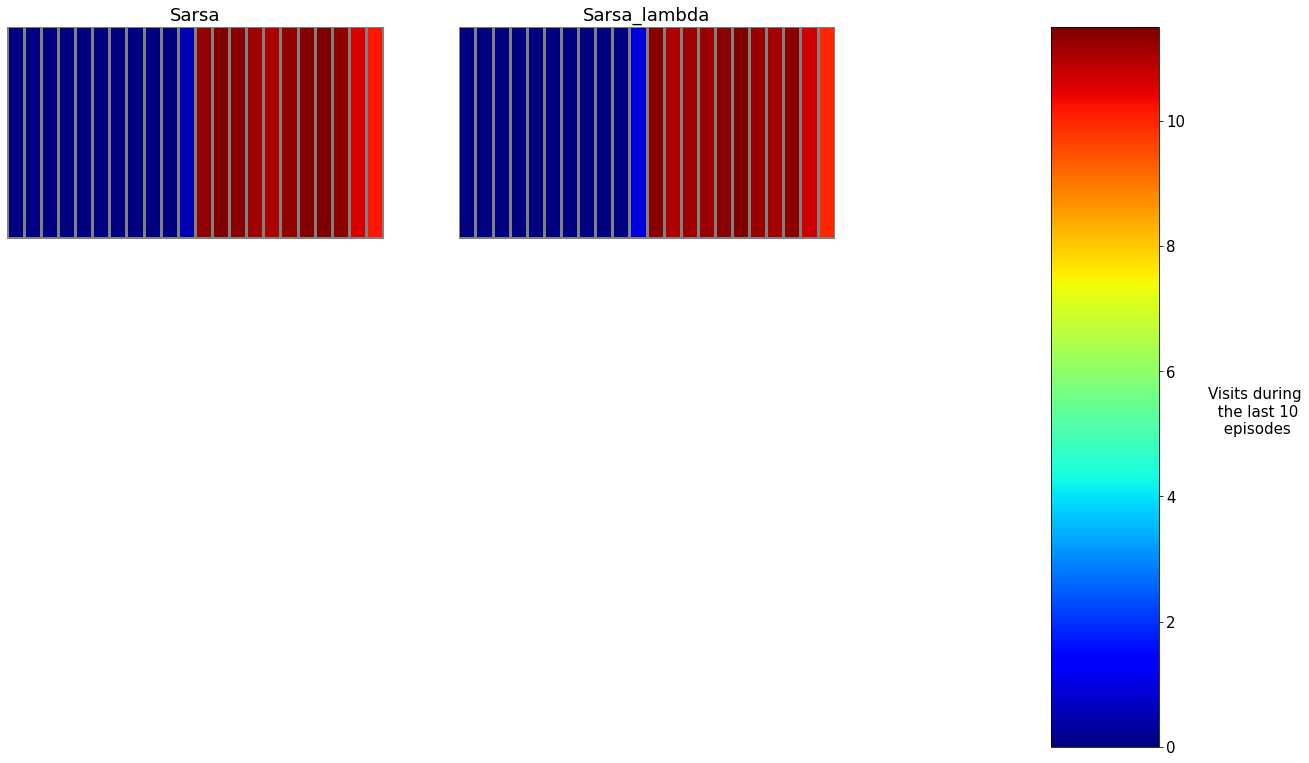

In [68]:
plt.figure(figsize=(20,10))
tmp={"NN": "Uniform", "NNP": "Uncertainty", "NNT":"Diversity"}
env = Environment()
env.env_init(env_info)
for i, algorithm in enumerate(list(agents.keys())): 
    position = int(f"32{i+1}")
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[env_name][algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((env.rows,env.cols))
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2, cmap='jet')
    plt.title(tmp.get(algorithm, algorithm))
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

In [258]:
# all_reward_sums = deepcopy(metrics['ve'])
all_reward_sums = deepcopy(metrics['msbpe'])
# all_reward_sums = deepcopy(metrics['all_reward_sums'])

In [332]:
num_runs = 20
num_episodes = 300

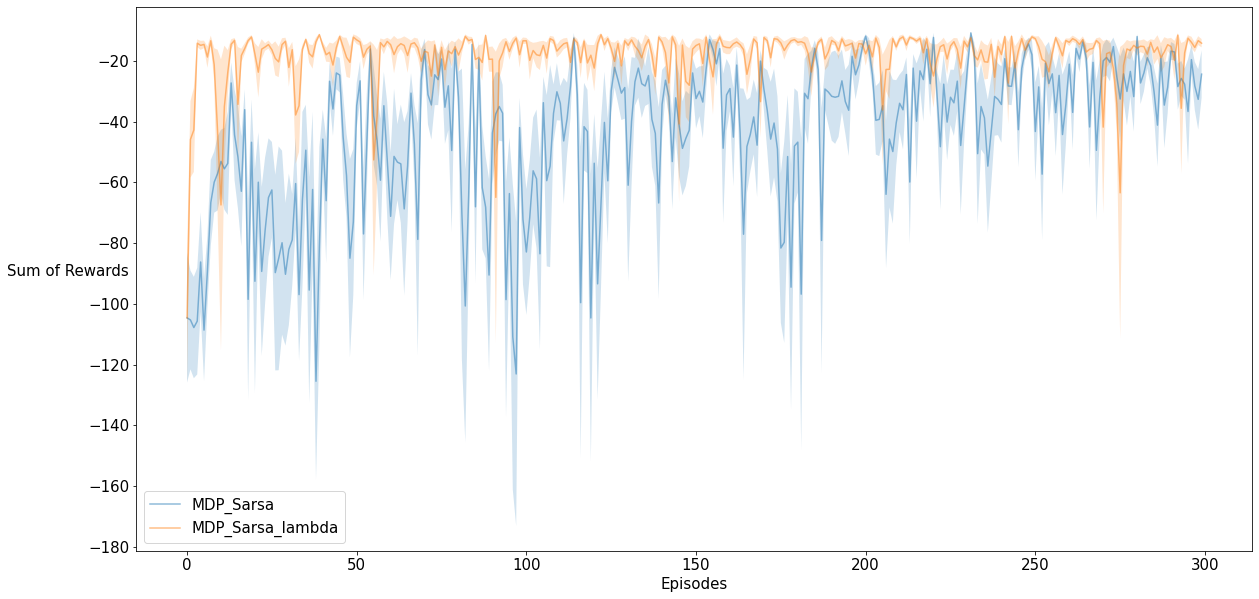

In [89]:
tmp={"NN": "Uniform", "NNP": "Uncertainty", "NNT":"Diversity"}
tmp1={'DoorWorldWide3':'GridWorldD3','DoorWorldWide11':'DoorWorldWide13X13D4'}
plt.figure(figsize=(20,10))
for env in env_infos:
    for i, algorithm in enumerate(list(agents.keys())):
        if algorithm not in all_reward_sums[env]:
            continue
        algorithm_means = -np.mean(all_reward_sums[env][algorithm], axis=0)
#         algorithm_means = np.mean(all_reward_sums[env][algorithm], axis=0)
        algorithm_stds = np.std(all_reward_sums[env][algorithm], axis=0)
        plt.plot(algorithm_means, label=tmp1.get(env,env)+'_'+tmp.get(algorithm, algorithm),
                 alpha=0.5)
        plt.fill_between(range(num_episodes), algorithm_means + algorithm_stds/np.sqrt(num_runs), algorithm_means - algorithm_stds/np.sqrt(num_runs), alpha=0.2)
# plt.ylabel("RMSE",rotation=0, labelpad=20)
plt.ylabel("Sum of Rewards",rotation=0, labelpad=20)
plt.xlabel("Episodes")
# plt.ylim(0,.002)
# plt.ylim(-50,0)
# plt.ylim(0,.006)
# plt.plot([0,500],[-18,-18])
# plt.title("learning rate search")
# plt.title("Nonstationary Policy in 5-state RandomWalk (buffer_size=1000)")
# plt.title("Value Error under Random Policy (20-state RandomWalk|buffer_size=1000)")

plt.legend()
plt.show()


In [90]:
print("agent", "Average rewards", "SEM", sep='\t')
for env in env_infos:
    for algo in agents.keys():
        if algo in all_reward_sums[env]:
            print(algo, -np.around(np.mean(np.array(all_reward_sums[env][algo])[:,100:]),decimals=4), np.around(np.std(np.mean(np.array(all_reward_sums[env][algo])[:,:], axis=1))/np.sqrt(num_runs),decimals=4), sep='\t')

agent	Average rewards	SEM
Sarsa	-35.62	1.8248
Sarsa_lambda	-16.994	0.6764
